In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd

import seaborn as sns
import os
import math

import scvi
from scvi.model.utils import mde
import torch

In [58]:
print(scvi.__version__)

1.1.2


In [59]:
if torch.cuda.is_available():
    print(f"CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

CUDA is available. GPU: NVIDIA GeForce RTX 4060


In [60]:
main_analysis_clustering_res={
    'Skin':0.7
}

n_epochs=1200
top_n_genes=3000

subsets_definition={
    'Skin':'tissue in ["Non-lesional skin","Lesional skin"]'
}

analysis_name="Skin"


In [61]:
linear=False
if (linear):
    model_name="scvimodel_{}epochs_linear_top{}_{}_2".format(n_epochs,top_n_genes,analysis_name)
else:
    model_name="scvimodel_{}epochs_top{}_{}_2".format(n_epochs,top_n_genes,analysis_name)
    
data_folder=os.path.join(".","data")
results_folder=os.path.join(data_folder,"ANALYSIS_SCVI_2")
if not (os.path.exists(results_folder)):
    os.makedirs(results_folder)
    
model_folder=os.path.join(results_folder,model_name)

In [62]:
adata = sc.read_csv("data\SC_GEO_raw_counts.csv")


c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [63]:
adata_prac = adata.copy()
adata_prac.var_names_make_unique()

# Assign gene names (ensure gene names are in the same order as in the raw counts file)
genes = pd.read_csv("data\SC_GEO_genes.csv")
adata_prac.var_names = genes['gene']

# Assign cell metadata (ensure cell barcodes are in the same order as the columns in the raw counts file)
cells = pd.read_csv("data\SC_GEO_cells.csv")
adata_prac.obs = cells.set_index('barcode')  # Make sure 'barcode' is the index



c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [65]:
if 'pass_QC' in cells.columns:
    adata_prac = adata_prac[adata_prac.obs['pass_QC'].astype(bool)].copy()

# Step 1: Initial Gene Filtering
# Filter genes expressed in more than 10% of the cells
sc.pp.filter_genes(adata_prac, min_cells=int(0.1 * adata_prac.n_obs))
# Calculate the mean expression for each gene and filter further
#adata_prac.var['mean_expression'] = adata_prac.X.mean(axis=0)
#adata_prac = adata_prac[:, (adata_prac.var['mean_expression'] > 1.5) & (adata_prac.var['n_cells'] > 5)]

adata_prac.var['avgExpr']=np.transpose(
    np.divide(np.sum(adata_prac.X,axis=0),
              np.sum(adata_prac.X>0,axis=0)
             )
)

adata_prac.var['pass_QC']=(
    (
        (adata_prac.var['n_cells']>5) & 
        (~adata_prac.var['avgExpr'].isna()) & 
        (adata_prac.var['avgExpr']>1.5)
    )
)
adata_prac=adata_prac[: ,adata_prac.var['pass_QC']]

adata_prac.var.pass_QC.value_counts()
adata_prac.raw = adata_prac

c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [66]:
adata_prac.obs.

AnnData object with n_obs × n_vars = 56114 × 4014
    obs: 'num_genes', 'umis', 'mt_perc', 'ribo_perc', 'batch', 'patient', 'visit', 'tissue', 'cell_type', 'pass_QC'
    var: 'n_cells', 'avgExpr', 'pass_QC'

In [8]:
external_data_file="data/healthy.h5ad"
external_data_ori=sc.read_h5ad(external_data_file).raw.to_adata()

In [9]:
external_data = external_data_ori.copy()

external_data.obs.columns=['sample','Status','Site','tissue','location','patient','sex','cell_type']
external_data.obs=external_data.obs.drop(['Status','Site','location','sex'],axis=1)
external_data.obs['hto_demux']=None
external_data.obs['batch']=external_data.obs['sample']
external_data.obs['pass_QC']=True
external_data.obs['visit']=None
external_data.obs['nGenes']=np.sum(external_data.X > 0,axis=1)
external_data.obs['nUMIs']=np.sum(external_data.X,axis=1)

In [10]:
# compare adata_prac.obs['cell_type'] and cell_types_scANVI['C_scANVI'] with same barcode

paper_cell_type = adata_prac.obs[['cell_type']]

In [67]:
cell_types_scANVI = pd.read_csv("./data/ANALYSIS_SCVI_2/cell_types_scANVI.csv")
cell_types_scANVI.C_scANVI.unique()

array(['Tc', 'F2', 'VE3', 'Th', 'Macro_2', 'DC2', 'VE2', 'Macro_1',
       'Pericyte_2', 'ILC1_NK', 'Inf_mac', 'Treg', 'NK', 'VE1', 'LE1',
       'ILC2', 'Mono_mac', 'Melanocyte', 'F3', 'MigDC', 'ILC1_3',
       'Plasma', 'LE2', 'Pericyte_1', 'moDC', 'DC1', 'migLC',
       'Undifferentiated_KC', 'Mast_cell', 'Differentiated_KC', 'F1',
       'Schwann_1', 'LC', 'Schwann_2'], dtype=object)

In [68]:
# make barcode of cell_type_scANVI in index
my_cell_types = cell_types_scANVI.set_index('barcode')

# concatenate paper_cell_type and my_cell_types by index
cell_types = pd.concat([paper_cell_type, my_cell_types], axis=1)

cell_type_nomenclature={
    'Tc':'Cytotoxic T-cells',
    'Th':'Helper T-cells',
    'Treg':'Regulatory T-cells',
    'ILC1_NK':'Innate lymphoid cells 1/Natural killer cells',
    'ILC1_3':'Innate lymphoid cells 1/3',
    'Mono_mac':'Monocyte derived Macrophages',
    'Macro_1':'Macrophage 1',
    'Macro_2':'Macrophage 2',
    'Inf_mac':'Macrophage Inflamatory',
    'migLC':'Migratory Langerhans cells',
    'MigDC':'Migratory Dendritic cells',
    'moDC':'Monocyte derived Dendritic cells',
    'DC1':'Dendritic cells 1',
    'DC2':'Dendritic cells 1',
    'Mast_cell':'Mast cells',
    'Pericyte_1':'Perictyes 1',
    'F2':'Fibroblast 2',
    'F1':'Fibroblast 1',
    'Melanocyte':'Melanocytes',
    'VE2':'Vascular endothelial cells 2',
    'VE1':'Vascular endothelial cells 1',
    'Differentiated_KC':'Differentiated Keratinocytes',
    'Undifferentiated_KC':'Undifferentiated Keratinocytes',
    'VE3':'Vascular endothelial cells 3',
    'LE2':'Lymphatic endothelial cells 2',
    'LE1':'Lymphatic endothelial cells 1',
    'F3':'Fibroblast 3',
    'Pericyte_2':'Perictyes 2',
    'Plasma':'Plasma cells',
    'NK':'Natural killer cells',
    'ILC2':'Innate lymphoid cells 2',
    'Schwann_1':'Schwann cells 1',
    'Schwann_2':'Schwann cells 2',
    'LC':'Langerhans cells'
}

# change C_scANVI with cell_type_nomenclature if it is in cell_type_nomenclature
cell_types['C_scANVI'] = cell_types['C_scANVI'].apply(lambda x: cell_type_nomenclature[x] if x in cell_type_nomenclature else x+'*')
cell_types

cell_type  \
barcode                                             
AAACCCATCCATCGTC-1              Cytotoxic T-cells   
AAACGAAAGTTGTCAC-1                   Fibroblast 2   
AAACGCTCAATTGTGC-1   Vascular endothelial cells 2   
AAACGCTTCGTCTCAC-1                 Helper T-cells   
AAAGAACAGGGCAACT-1                   Fibroblast 2   
...                                           ...   
TTGGATGGTAACCAGG-20                  Fibroblast 2   
TTGGGCGGTCGCAACC-20  Monocyte derived Macrophages   
TTGGGTAAGGTCTTTG-20             Dendritic cells 1   
TTGTTTGTCGGATAAA-20  Vascular endothelial cells 2   
TTTGTTGGTCGTGATT-20                  Fibroblast 2   

                                         C_scANVI  
barcode                                            
AAACCCATCCATCGTC-1              Cytotoxic T-cells  
AAACGAAAGTTGTCAC-1                   Fibroblast 2  
AAACGCTCAATTGTGC-1   Vascular endothelial cells 3  
AAACGCTTCGTCTCAC-1                 Helper T-cells  
AAAGAACAGGGCAACT-1                   Fibroblast 2  
...                                           ...  
TTGGATGGTAACCAGG-20                  Fibroblast 2  
TTGGGCGGTCGCAACC-20  Monocyte derived Macrophages  
TTGGGTAAGGTCTTTG-20             Dendritic cells 1  
TTGTTTGTCGGATAAA-20  Vascular endothelial cells 3  
TTTGTTGGTCGTGATT-20                  Fibroblast 2  

[56114 rows x 2 columns]

In [73]:
cell_types.C_scANVI.value_counts()

C_scANVI
Helper T-cells                                  14251
Macrophage 1                                     6943
Cytotoxic T-cells                                5709
Fibroblast 2                                     4392
Monocyte derived Macrophages                     3254
Macrophage 2                                     3153
Vascular endothelial cells 2                     2947
Regulatory T-cells                               2824
Fibroblast 3                                     2045
Dendritic cells 1                                1153
Mast cells                                        999
Vascular endothelial cells 3                      923
Monocyte derived Dendritic cells                  800
Innate lymphoid cells 1/Natural killer cells      733
Perictyes 2                                       634
Migratory Langerhans cells                        619
Differentiated Keratinocytes                      572
Fibroblast 1                                      490
Vascular endothelia

In [13]:
subsets_config={
    "Skin":{
        'Lymphoid:CD4':['Th'],
        'Lymphoid:CD8':['Tc'],
        'Lymphoid:NK':['ILC1_NK','ILC1_3', 'NK', 'ILC2'],
        'Lymphoid:Tregs':['Treg'],
        'Myeloid:Macrophages':['Macro_1','Macro_2','Mono_mac','Inf_mac'],
        'Myeloid:DC':['moDC','MigDC','migLC','DC1','DC2'],
        'Endothelium:Vascular':['VE2','VE1', 'VE3'],
        'Endothelium:Lymphatic':['LE1','LE2'],
        'Epithelium:Keratinocyte':['Differentiated_KC','Undifferentiated_KC'],
        'Epithelium:Melanocyte':['Melanocyte'],
        'Structural:Fibroblasts':['F1','F2', 'F3'],
        'Structural:Perycite':['Pericyte_1', 'Pericyte_2'],
        'Other:Mast':['Mast_cell'],
        'Other:Plasma':['Plasma'],
        'Other:Schwann':['Schwann_1','Schwann_2'],
        'Other:Langerhans':['LC']
    }
}

my_own_cell_type={
    'Endothelial cells':['VE2','VE1', 'VE3', 'LE1','LE2'],
    'Fibroblasts':['F1', 'F2', 'F3'],
    'Keratinocytes':['Differentiated_KC','Undifferentiated_KC'],
    'Lymphoid cells':['Th','Tc','Treg','ILC1_NK','ILC1_3', 'NK', 'ILC2'],
    'Macrophages':['Macro_1','Macro_2','Mono_mac','Inf_mac'],
    'Mast cells':['Mast_cell'],
    'Melanocytes':['Melanocyte'],
    'Pericytes':['Pericyte_1', 'Pericyte_2'],
    'Dendritic cells':['moDC','MigDC','migLC','DC1','DC2'],
    'Plasma cells':['Plasma'],
    'Schwann cells':['Schwann_1','Schwann_2'],
    'Langerhans cells':['LC']  
}

my_own_cell_type_colors={
    'Endothelial cells':'#FF0000',
    'Fibroblasts':'#00FF00',
    'Keratinocytes':'#0000FF',
    'Lymphoid cells':'#FFFF00',
    'Macrophages':'#00FFFF',
    'Mast cells':'#FF00FF',
    'Melanocytes':'#FF7F00',
    'Pericytes':'#FFD800',
    'Dendritic cells':'#FFD800',
    'Plasma cells':'#FFD800',
    'Schwann cells':'#FFD800',
    'Langerhans cells':'#FFD800'
}

cell_type_colors={
    'Cytotoxic T-cells':'#0015FF',
    'Helper T-cells':'#7718F6',
    'Regulatory T-cells':'#ED1AED',
    'Innate lymphoid cells 1/Natural killer cells':'#07C8F9',
    'Innate lymphoid cells 1/3':'#9E18F3',
    'Monocyte derived Macrophages':'#BFFF00',
    'Macrophage 1':'#B4F50F',
    'Macrophage 2':'#A9EA1E',
    'Macrophage Inflamatory':'#9DE02D',
    'Migratory Langerhans cells':'#92D63D',
    'Migratory Dendritic cells':'#87CB4C',
    'Monocyte derived Dendritic cells':'#7CC15B',
    'Dendritic cells 1':'#70B66A',
    'Dendritic cells 1':'#65AC79',
    'Mast cells':'#1AAEED',
    'Perictyes 1':'#2F474C',
    'Fibroblast 2':'#0F3D50',
    'Fibroblast 1':'#90643E',
    'Melanocytes':'#505147',
    'Vascular endothelial cells 2':'#D10303',
    'Vascular endothelial cells 1':'#460A0A',
    'Lymphatic endothelial cells 2':'#00FF48',
    'Differentiated Keratinocytes':'#00FFE5',
    'Undifferentiated Keratinocytes':'#354741',
    'Vascular endothelial cells 3':'#FF00FF',
    'Lymphatic endothelial cells 1':'#FF0000',
    'Fibroblast 3':'#FF7F00',
    'Perictyes 2': '#FFD800',
    'Plasma cells': '#FFD800',
    'Natural killer cells':'#FFD800',
    'Innate lymphoid cells 2':'#FFD800',
    'Schwann cells 1':'#FFD800',
    'Schwann cells 2':'#FFD800',
    'Langerhans cells':'#FFD800'
}

tissue_colors={
    'Lesional skin':'#8E1010',
    'Non-lesional skin':'#0A85ED'
}



clusters_subsets={
    'Skin':{
        '0':'Myeloid:Lesional Macrophages',
        '1':'T-cells:Lesional Th Cells',
        '2':'T-cells:Non-lesional Th Cells',
        '3':'Myeloid:Non-lesional Macrophages',
        '4':'Fibroblasts:Non-lesional Fibroblasts',
        '5':'Endothelium:Vascular Endothelial Cells',
        '6':'T-cells:Cytotoxic T-cells',
        '7':'T-cells:Other T-cells',
        '8':'T-cells:Tregs',
        '9':'Fibroblasts:Lesional Fibroblasts',
        '10':'Pericytes:Pericytes',
        '11':'Mast cells:Mast cells',
        '12':'T-cells:NK cells',
        '13':'Myeloid:Other Macrophages',
        '14':'Keratinocytyes:Keratinocytyes',
        '15':'Endothelium:Lymphatic Endothelial Cells',
        '16':'DC:DC',
        '17':'Melanocytes:Melanocytes',
        '18':'B-cells:B-cells',
        '19':'DC:DC Other'        
    }
}

palette=sns.color_palette("husl",20).as_hex()

clusters_subsets_colors={
    'Lesional Macrophages':palette[0],
    'Lesional Th Cells':palette[1],
    'Non-lesional Th Cells':palette[2],
    'Non-lesional Macrophages':palette[3],
    'Non-lesional Fibroblasts':palette[4],
    'Vascular Endothelial Cells':palette[5],
    'Cytotoxic T-cells':palette[6],
    'Other T-cells':palette[7],
    'Tregs':palette[8],
    'Lesional Fibroblasts':palette[9],
    'Pericytes':palette[10],
    'Mast cells':palette[11],
    'NK cells':palette[12],
    'Other Macrophages':palette[13],
    'Keratinocytyes':palette[14],
    'Lymphatic Endothelial Cells':palette[15],
    'DC':palette[16],
    'Melanocytes':palette[17],
    'B-cells':palette[18],
    'DC Other':palette[19]
}


other_colors=sns.color_palette("husl",7).as_hex()
cluster_lineage_colors={
    'T-cells':'#2A2AFF',
    'Fibroblasts':'#8DD35F',
    'Myeloid':'#FF5555',
    'Endothelium':other_colors[0],
    'Pericytes':other_colors[1],
    'Mast cells':other_colors[2],
    'Keratinocytyes':other_colors[3],
    'DC':other_colors[4],
    'Melanocytes':other_colors[5],
    'B-cells':other_colors[6]
    
}

In [48]:
import matplotlib.colors as mcolors
import numpy as np

# 주어진 색상 딕셔너리
cell_type_colors={
    'Cytotoxic T-cells':'#0015FF',
    'Helper T-cells':'#7718F6',
    'Regulatory T-cells':'#ED1AED',
    'Innate lymphoid cells 1/Natural killer cells':'#07C8F9',
    'Innate lymphoid cells 1/3':'#9E18F3',
    'Monocyte derived Macrophages':'#BFFF00',
    'Macrophage 1':'#B4F50F',
    'Macrophage 2':'#A9EA1E',
    'Macrophage Inflamatory':'#9DE02D',
    'Migratory Langerhans cells':'#92D63D',
    'Migratory Dendritic cells':'#87CB4C',
    'Monocyte derived Dendritic cells':'#7CC15B',
    'Dendritic cells 1':'#70B66A',
    'Dendritic cells 1':'#65AC79',
    'Mast cells':'#1AAEED',
    'Perictyes 1':'#2F474C',
    'Fibroblast 2':'#0F3D50',
    'Fibroblast 1':'#90643E',
    'Melanocytes':'#505147',
    'Vascular endothelial cells 2':'#D10303',
    'Vascular endothelial cells 1':'#460A0A',
    'Lymphatic endothelial cells 2':'#00FF48',
    'Differentiated Keratinocytes':'#00FFE5',
    'Undifferentiated Keratinocytes':'#354741',
    'Vascular endothelial cells 3':'#FF00FF',
    'Lymphatic endothelial cells 1':'#FF0000',
    'Fibroblast 3':'#FF7F00',
    'Perictyes 2': '#FFD800',
    'Plasma cells': '#FFD800',
    'Natural killer cells':'#FFD800',
    'Innate lymphoid cells 2':'#FFD800',
    'Schwann cells 1':'#FFD800',
    'Schwann cells 2':'#FFD800',
    'Langerhans cells':'#FFD800'
}

new_colors={
'Endothelial cells': '#e377c2',
'Fibroblasts': '#92D63D',
'Keratinocytes': '#7CC15B',
'Lymphoid cells': '#0015FF', 
'Macrophages': '#D10303', 
'Mast cells': '#BFFF00', 
'Melanocytes': '#1AAEED', 
'Pericytes': '#90643E', 
'Dendritic cells': '#07C8F9', 
'Plasma cells': '#0F3D50', 
'Schwann cells': '#2F474C', 
'Langerhans cells': '#460A0A'
}

In [45]:
# Endothelial cells와 Schwann cells 색깔 바꾸기
new_colors['Endothelial cells'] = my_own_cell_type_colors['Endothelial cells']

In [15]:
subset_mapping=dict()

subsets=subsets_config[analysis_name]
for subset in subsets:
    for cell_type in subsets[subset]:
        if (cell_type in subset_mapping):
            raise Exception("CELL TYPE: {} was defined in multiple subsets".format(cell_type))

        subset_mapping[cell_type]=subset

In [16]:
cluster_column="leiden_scVI_{}".format(analysis_name)

In [17]:
cell_types = cell_types.rename(columns={'C_scANVI': 'cell_type_scANVI'})
cell_types = cell_types[['cell_type_scANVI']]

In [18]:
adata_prac.obs = pd.concat([adata_prac.obs, cell_types], axis=1)

In [19]:
# cell_type_scANVI의 unique값을 가져온다.
adata_prac.obs['cell_type'] = adata_prac.obs['cell_type_scANVI']
metadata = adata_prac.obs

In [20]:
adata_prac.layers['counts'] = adata_prac.X.copy()
sc.pp.normalize_total(adata_prac, target_sum=10e4)
sc.pp.log1p(adata_prac)
sc.pp.highly_variable_genes(adata_prac, flavor='seurat_v3', layer='counts', n_top_genes=top_n_genes, subset=False, batch_key='batch')

In [21]:
adata_prac=adata_prac[:,adata_prac.var['highly_variable']]
        
adata_prac.raw=adata_prac

if (adata_prac):
    scvi.model.LinearSCVI.setup_anndata(adata_prac, layer="counts",batch_key='batch')
    model = scvi.model.LinearSCVI(adata_prac)
else:
    scvi.model.SCVI.setup_anndata(adata_prac, layer="counts",batch_key='batch')
    model = scvi.model.SCVI(adata_prac)
model.train(max_epochs=n_epochs)
model.save(model_folder, overwrite=True, save_anndata=True)

Z_hat = model.get_latent_representation()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\sangyeon\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 1200/1200: 100%|██████████| 1200/1200 [41:00<00:00,  2.15s/it, v_num=1, train_loss_step=3.05e+3, train_loss_epoch=2.94e+3]

`Trainer.fit` stopped: `max_epochs=1200` reached.


Epoch 1200/1200: 100%|██████████| 1200/1200 [41:00<00:00,  2.05s/it, v_num=1, train_loss_step=3.05e+3, train_loss_epoch=2.94e+3]


In [22]:
adata_prac.obsm["X_scVI"] = Z_hat

train_history=pd.DataFrame(model.history['elbo_train'])
train_history.to_csv(os.path.join(model_folder,"train_history.csv"))

In [23]:
# adata_prac.obs.cell_type을 다시 cell_type_nomenclature의 key값으로 바꾼다.
adata_prac.obs['cell_type'] = adata_prac.obs['cell_type'].apply(lambda x: cell_type_nomenclature[x] if x in cell_type_nomenclature else x)
# '*'를 제거한다.
adata_prac.obs['cell_type'] = adata_prac.obs['cell_type'].apply(lambda x: x.replace('*',''))
adata_prac.obs['cell_type']

barcode
AAACCCATCCATCGTC-1                Cytotoxic T-cells
AAACGAAAGTTGTCAC-1                     Fibroblast 2
AAACGCTCAATTGTGC-1     Vascular endothelial cells 3
AAACGCTTCGTCTCAC-1                   Helper T-cells
AAAGAACAGGGCAACT-1                     Fibroblast 2
                                   ...             
TTGGATGGTAACCAGG-20                    Fibroblast 2
TTGGGCGGTCGCAACC-20    Monocyte derived Macrophages
TTGGGTAAGGTCTTTG-20               Dendritic cells 1
TTGTTTGTCGGATAAA-20    Vascular endothelial cells 3
TTTGTTGGTCGTGATT-20                    Fibroblast 2
Name: cell_type, Length: 56114, dtype: category
Categories (33, object): ['Cytotoxic T-cells', 'Dendritic cells 1', 'Differentiated Keratinocytes', 'Fibroblast 1', ..., 'Undifferentiated Keratinocytes', 'Vascular endothelial cells 1', 'Vascular endothelial cells 2', 'Vascular endothelial cells 3']

In [24]:
adata_prac.obs['cell_type'] = my_cell_types['C_scANVI']

In [25]:
adata_prac.obs['cell_type'] = adata_prac.obs['cell_type'].map({cell_type: category
                                                                     for category, cell_types in my_own_cell_type.items()
                                                                     for cell_type in cell_types})

In [26]:
adata_prac.obs['cell_type']

barcode
AAACCCATCCATCGTC-1        Lymphoid cells
AAACGAAAGTTGTCAC-1           Fibroblasts
AAACGCTCAATTGTGC-1     Endothelial cells
AAACGCTTCGTCTCAC-1        Lymphoid cells
AAAGAACAGGGCAACT-1           Fibroblasts
                             ...        
TTGGATGGTAACCAGG-20          Fibroblasts
TTGGGCGGTCGCAACC-20          Macrophages
TTGGGTAAGGTCTTTG-20      Dendritic cells
TTGTTTGTCGGATAAA-20    Endothelial cells
TTTGTTGGTCGTGATT-20          Fibroblasts
Name: cell_type, Length: 56114, dtype: object

In [54]:
def perform_dim_reduction(adata, umap_neighbors=20, umap_dist=0.3):
    sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=umap_neighbors, key_added='scVI')
    sc.tl.umap(adata, min_dist=umap_dist,neighbors_key='scVI')
    sc.set_figure_params(figsize=(10,10))
    sc.pl.embedding(adata, basis='X_umap', color=["tissue","batch","cell_type"],size=8, ncols=3)
    
    return adata

In [28]:
my_own_cell_type

{'Endothelial cells': ['VE2', 'VE1', 'VE3', 'LE1', 'LE2'],
 'Fibroblasts': ['F1', 'F2', 'F3'],
 'Keratinocytes': ['Differentiated_KC', 'Undifferentiated_KC'],
 'Lymphoid cells': ['Th', 'Tc', 'Treg', 'ILC1_NK', 'ILC1_3', 'NK', 'ILC2'],
 'Macrophages': ['Macro_1', 'Macro_2', 'Mono_mac', 'Inf_mac'],
 'Mast cells': ['Mast_cell'],
 'Melanocytes': ['Melanocyte'],
 'Pericytes': ['Pericyte_1', 'Pericyte_2'],
 'Dendritic cells': ['moDC', 'MigDC', 'migLC', 'DC1', 'DC2'],
 'Plasma cells': ['Plasma'],
 'Schwann cells': ['Schwann_1', 'Schwann_2'],
 'Langerhans cells': ['LC']}

In [29]:
# adata_prac.obs['my_cell_types']에 my_cell_types를 barcode를 기준으로 넣어준다.

adata_prac.obs['my_cell_types'] = my_cell_types['C_scANVI']

In [30]:
# my_cell_types가 my_own_cell_type의 value에 있으면 my_own_cell_type의 key값으로 바꾼다.
# 주어진 딕셔너리를 사용하여 값을 바꾸기
adata_prac.obs['my_cell_types'] = adata_prac.obs['my_cell_types'].map({cell_type: category
                                                                     for category, cell_types in my_own_cell_type.items()
                                                                     for cell_type in cell_types})


In [31]:
adata_prac.obs['my_cell_types']

barcode
AAACCCATCCATCGTC-1        Lymphoid cells
AAACGAAAGTTGTCAC-1           Fibroblasts
AAACGCTCAATTGTGC-1     Endothelial cells
AAACGCTTCGTCTCAC-1        Lymphoid cells
AAAGAACAGGGCAACT-1           Fibroblasts
                             ...        
TTGGATGGTAACCAGG-20          Fibroblasts
TTGGGCGGTCGCAACC-20          Macrophages
TTGGGTAAGGTCTTTG-20      Dendritic cells
TTGTTTGTCGGATAAA-20    Endothelial cells
TTTGTTGGTCGTGATT-20          Fibroblasts
Name: my_cell_types, Length: 56114, dtype: object

In [52]:
colors=list()
for cell_type in adata_prac.obs['cell_type'].sort_values().unique():
    colors.append(new_colors[cell_type])

adata_prac.uns['cell_type_colors']=colors

colors=list()
for tissue in adata_prac.obs['tissue'].sort_values().unique():
    colors.append(tissue_colors[tissue])

adata_prac.uns['tissue_colors']=colors

colors=list()
for my_cell_type in adata_prac.obs['my_cell_types'].sort_values().unique():
    colors.append(new_colors[my_cell_type])

adata_prac.uns['my_cell_type_colors']=colors

In [35]:
adata_prac.var

n_cells    avgExpr  pass_QC  highly_variable  highly_variable_rank  \
gene                                                                           
HES4        12578   2.893147     True             True                 408.0   
ISG15       28578   3.801701     True             True                 482.5   
TNFRSF18    17696   2.963721     True             True                 640.5   
TNFRSF4     16011   3.851977     True             True                 453.5   
MXRA8        6237   4.288761     True             True                 322.0   
...           ...        ...      ...              ...                   ...   
MT-ND3      55057  31.775959     True             True                1532.5   
MT-ND4L     32441   2.848340     True             True                2413.0   
MT-ND4      55582  47.596398     True             True                1267.0   
MT-ND6      16906   2.170472     True             True                1789.0   
MT-CYB      55689  52.519726     True             True                1858.0   

              means    variances  variances_norm  highly_variable_nbatches  
gene                                                                        
HES4       0.648501     3.801098        2.101277                        20  
ISG15      1.936148    24.416057        2.023065                        20  
TNFRSF18   0.934633     4.757939        1.704251                        20  
TNFRSF4    1.099084    10.128795        2.096660                        20  
MXRA8      0.476690     3.928502        2.959240                        20  
...             ...          ...             ...                       ...  
MT-ND3    31.177407  2101.228787        0.892438                        14  
MT-ND4L    1.646701     6.766255        0.661567                         8  
MT-ND4    47.145151  4796.964781        1.060810                        17  
MT-ND6     0.653919     3.179069        0.870185                        17  
MT-CYB    52.121948  4140.965525        0.837660                        16  

[3000 rows x 9 columns]

In [56]:
adata_prac.obs

num_genes     umis   mt_perc  ribo_perc    batch patient  \
barcode                                                                         
AAACCCATCCATCGTC-1        1862   5165.0  6.602130  14.424008  P01_V00     P01   
AAACGAAAGTTGTCAC-1        3966  14825.0  5.268128  13.753794  P01_V00     P01   
AAACGCTCAATTGTGC-1        3056  13065.0  4.064294  24.975124  P01_V00     P01   
AAACGCTTCGTCTCAC-1        1615   5856.0  4.952186  29.525274  P01_V00     P01   
AAAGAACAGGGCAACT-1        3386  12693.0  3.324667  30.757110  P01_V00     P01   
...                        ...      ...       ...        ...      ...     ...   
TTGGATGGTAACCAGG-20       3872  15937.0  5.477819  13.020017  P11_V06     P11   
TTGGGCGGTCGCAACC-20       2283  11944.0  4.964836   9.954789  P11_V06     P11   
TTGGGTAAGGTCTTTG-20       3814  22565.0  2.428540  15.896299  P11_V06     P11   
TTGTTTGTCGGATAAA-20       3508  13577.0  9.236208  13.869042  P11_V06     P11   
TTTGTTGGTCGTGATT-20       4850  25112.0  2.178241   8.776680  P11_V06     P11   

                    visit             tissue          cell_type  pass_QC  \
barcode                                                                    
AAACCCATCCATCGTC-1    V00  Non-lesional skin     Lymphoid cells     True   
AAACGAAAGTTGTCAC-1    V00      Lesional skin        Fibroblasts     True   
AAACGCTCAATTGTGC-1    V00      Lesional skin  Endothelial cells     True   
AAACGCTTCGTCTCAC-1    V00      Lesional skin     Lymphoid cells     True   
AAAGAACAGGGCAACT-1    V00      Lesional skin        Fibroblasts     True   
...                   ...                ...                ...      ...   
TTGGATGGTAACCAGG-20   V06      Lesional skin        Fibroblasts     True   
TTGGGCGGTCGCAACC-20   V06      Lesional skin        Macrophages     True   
TTGGGTAAGGTCTTTG-20   V06      Lesional skin    Dendritic cells     True   
TTGTTTGTCGGATAAA-20   V06      Lesional skin  Endothelial cells     True   
TTTGTTGGTCGTGATT-20   V06      Lesional skin        Fibroblasts     True   

                                 cell_type_scANVI  _scvi_batch  _scvi_labels  \
barcode                                                                        
AAACCCATCCATCGTC-1              Cytotoxic T-cells            0             0   
AAACGAAAGTTGTCAC-1                   Fibroblast 2            0             0   
AAACGCTCAATTGTGC-1   Vascular endothelial cells 3            0             0   
AAACGCTTCGTCTCAC-1                 Helper T-cells            0             0   
AAAGAACAGGGCAACT-1                   Fibroblast 2            0             0   
...                                           ...          ...           ...   
TTGGATGGTAACCAGG-20                  Fibroblast 2           17             0   
TTGGGCGGTCGCAACC-20  Monocyte derived Macrophages           17             0   
TTGGGTAAGGTCTTTG-20             Dendritic cells 1           17             0   
TTGTTTGTCGGATAAA-20  Vascular endothelial cells 3           17             0   
TTTGTTGGTCGTGATT-20                  Fibroblast 2           17             0   

                         my_cell_types leiden_scVI_Skin  umap_density_tissue  \
barcode                                                                        
AAACCCATCCATCGTC-1      Lymphoid cells                6             0.513392   
AAACGAAAGTTGTCAC-1         Fibroblasts                2             0.371555   
AAACGCTCAATTGTGC-1   Endothelial cells                4             0.280486   
AAACGCTTCGTCTCAC-1      Lymphoid cells                8             0.507812   
AAAGAACAGGGCAACT-1         Fibroblasts                2             0.210375   
...                                ...              ...                  ...   
TTGGATGGTAACCAGG-20        Fibroblasts                2             0.431055   
TTGGGCGGTCGCAACC-20        Macrophages                7             0.465046   
TTGGGTAAGGTCTTTG-20    Dendritic cells                7             0.311976   
TTGTTTGTCGGATAAA-20  Endothelial cells                4  

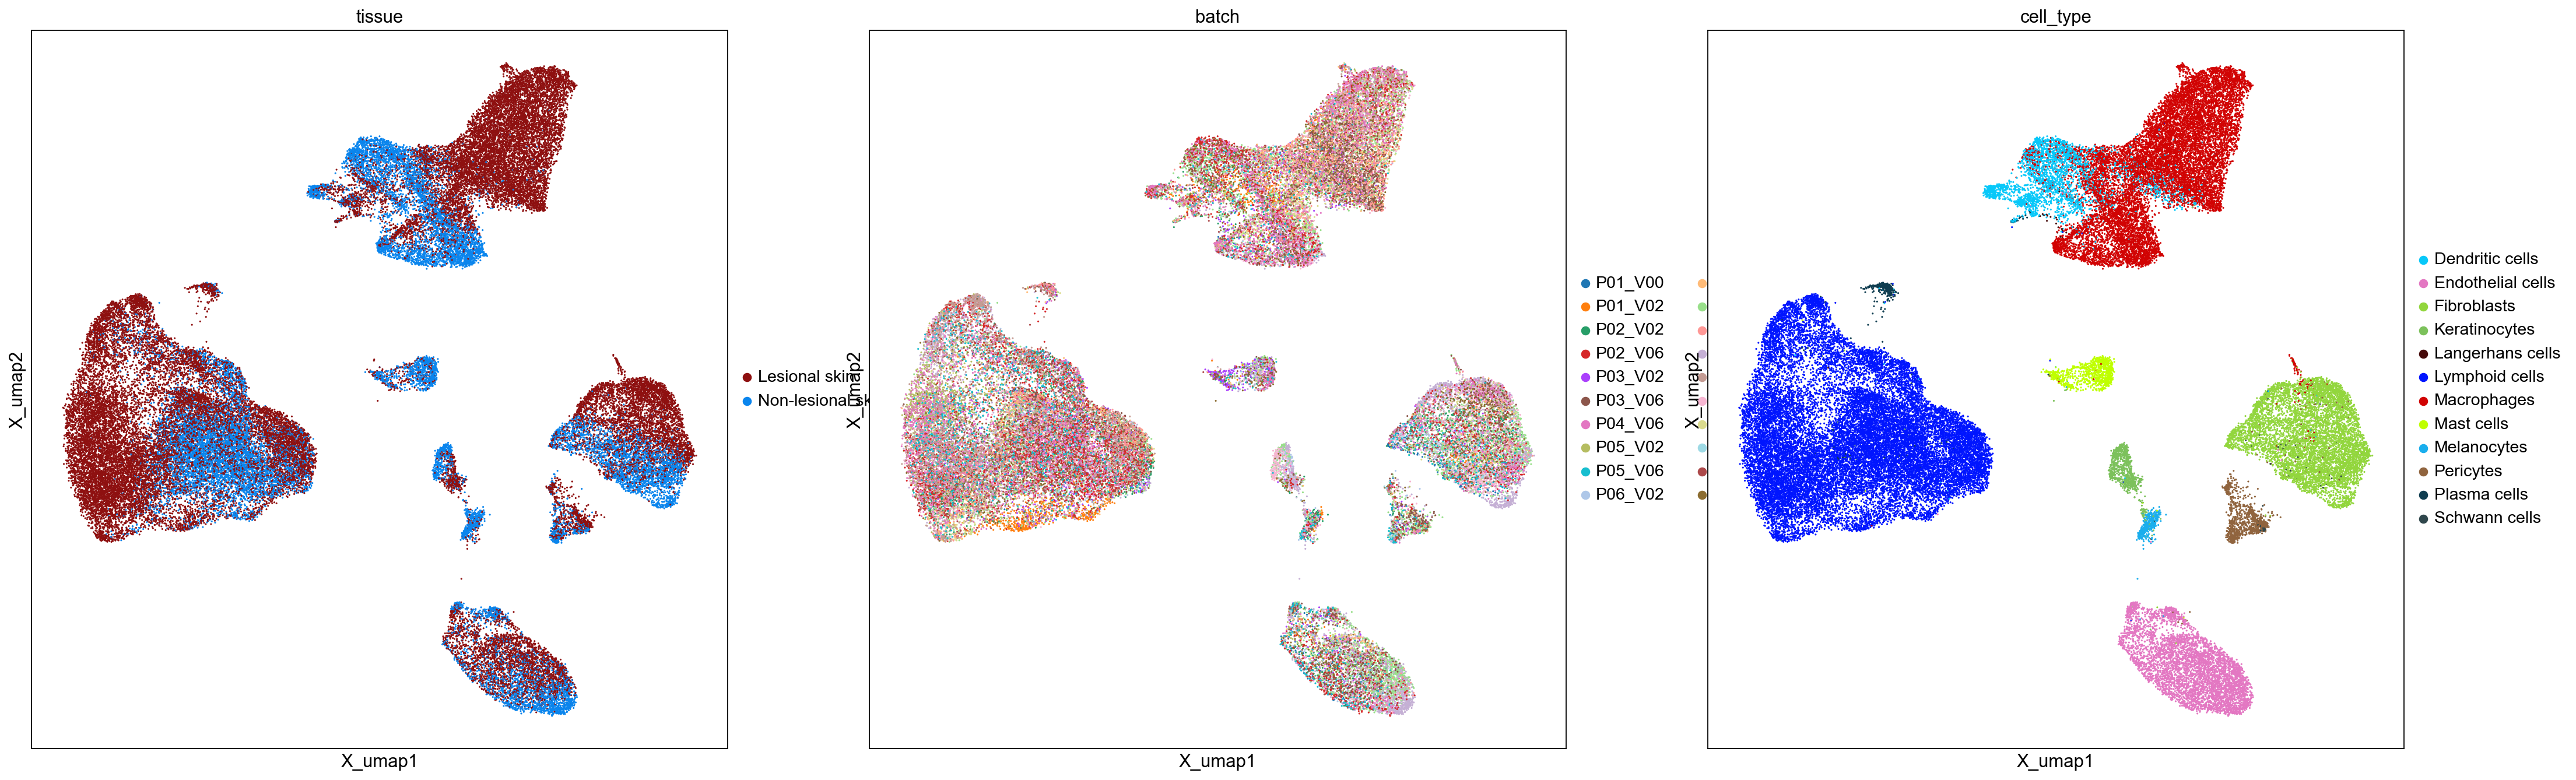

In [55]:
adata_prac=perform_dim_reduction(adata_prac, umap_neighbors=50, umap_dist=0.3)

In [37]:
adata_prac.obsm["X_umap"]

array([[-1.0494834,  1.3112414],
       [13.313941 ,  3.2487717],
       [ 9.189065 , -5.94484  ],
       ...,
       [ 5.5906687, 12.863906 ],
       [ 8.912373 , -5.201797 ],
       [13.521472 ,  2.421064 ]], dtype=float32)

In [38]:
import leidenalg

%matplotlib inline

In [39]:
adata_prac.obsm

AxisArrays with keys: X_scVI, X_umap

In [40]:
def perform_clustering(adata,                       
                       clustering_resolution,
                       cluster_column=cluster_column):
    
    print("Resolution: {}".format(clustering_resolution))
    
    sc.tl.leiden(adata, key_added=cluster_column, partition_type=leidenalg.RBConfigurationVertexPartition,resolution=clustering_resolution,neighbors_key='scVI')
    
    sc.set_figure_params(figsize=(10,10))
    
    sc.pl.embedding(adata, basis='X_umap', color=cluster_column,legend_loc='on data',size=15)
    
    return adata

Resolution: 0.7


C:\Users\sangyeon\AppData\Local\Temp\ipykernel_24344\3513185167.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added=cluster_column, partition_type=leidenalg.RBConfigurationVertexPartition,resolution=clustering_resolution,neighbors_key='scVI')


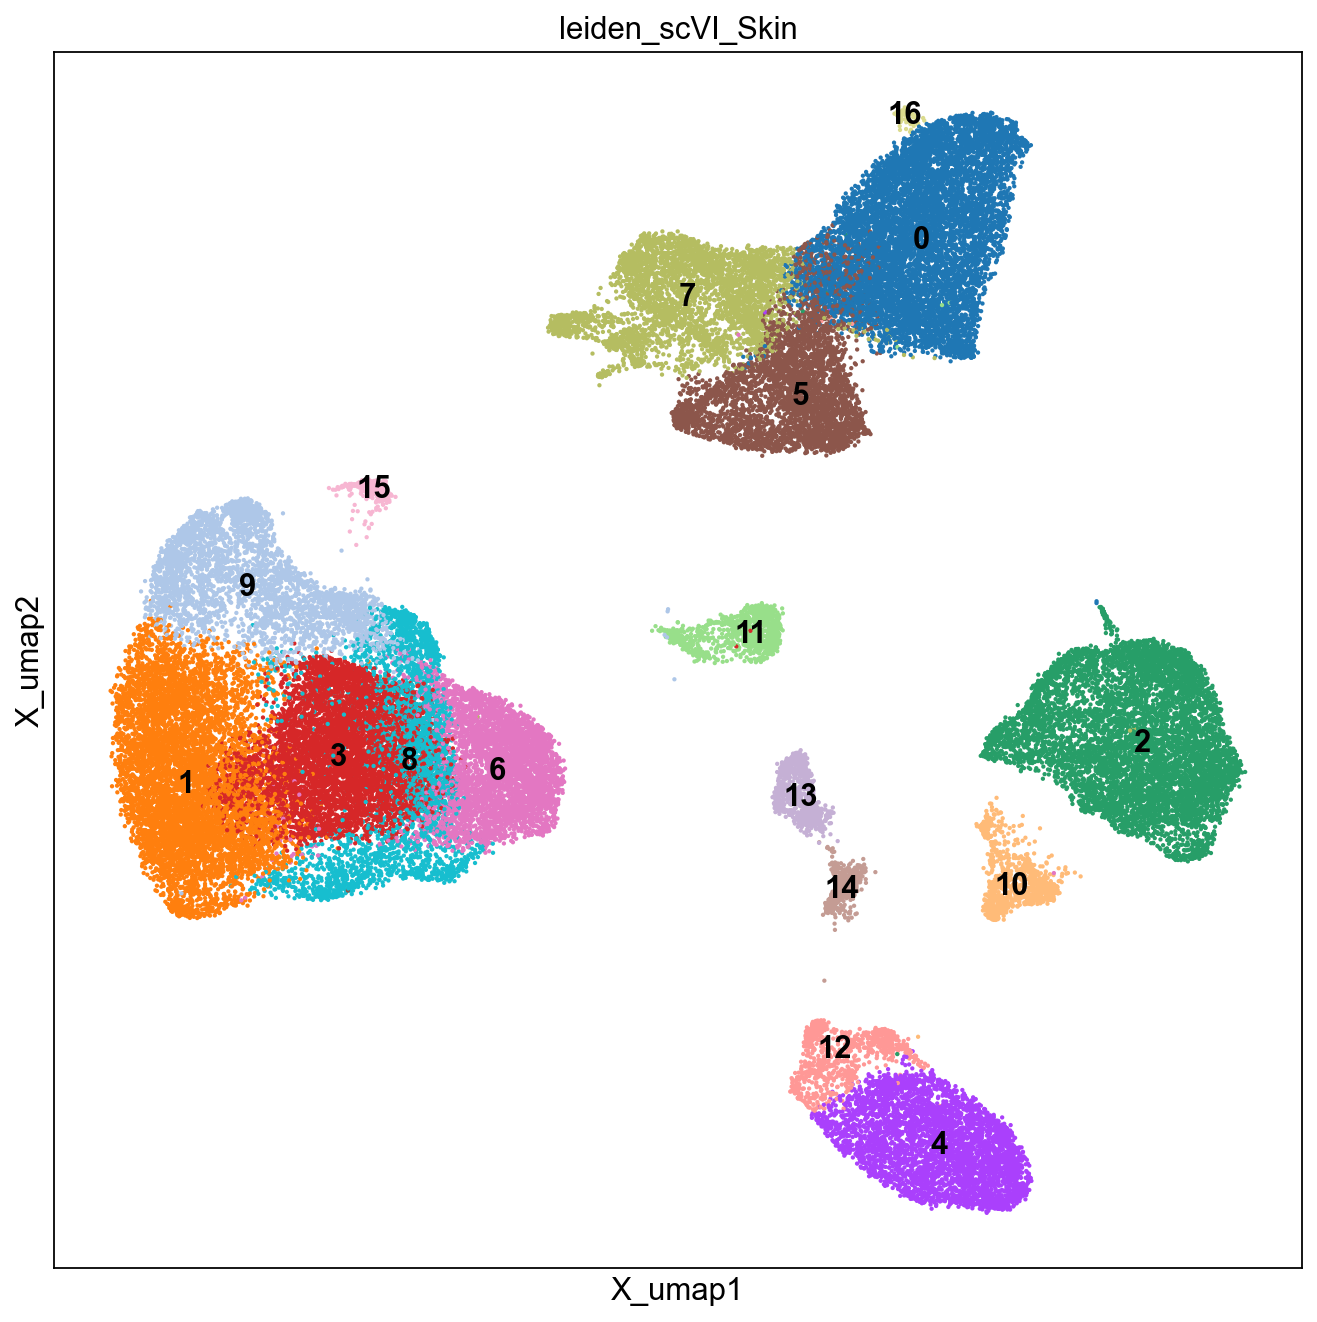

In [41]:
adata_prac=perform_clustering(adata_prac,clustering_resolution=main_analysis_clustering_res[analysis_name])

In [42]:
def plot_densities(adata,
                  subset_mapping=subset_mapping):
    
    if (len(adata.obs['tissue'].unique())>1):
        sc.tl.embedding_density(adata, basis='umap', groupby="tissue")
        sc.pl.embedding_density(adata, basis='umap', groupby="tissue",groups="all")
        
    if "subset" in adata.obs.columns:
        adata.obs=adata.obs.drop("subset",axis=1)

    adata.obs["subset"]=adata.obs['cell_type_scANVI'].map(subset_mapping)

    
#     sc.tl.embedding_density(adata, basis='umap', groupby="subset")
#     sc.pl.embedding_density(adata, basis='umap', groupby="subset",groups="all",ncols=3)
    
    sc.set_figure_params(figsize=(10,10))

    all_subsets=adata.obs["subset"].unique()

    nrows=math.ceil(len(all_subsets)/2)
    fig, ax = plt.subplots(nrows, 2, figsize=(20,8*nrows))
    ax=ax.reshape(-1)

    for i,subset in enumerate(all_subsets):
        colorby=adata.obs.loc[adata.obs["subset"]==subset,'cell_type_scANVI'].unique()
        sc.pl.umap(adata, color=['cell_type_scANVI'],size=20,alpha=0.5,groups=colorby,ax=ax[i], show=False)
        _ = ax[i].set_title(subset)

    
    for j in range(i+1,len(ax)):
        ax[j].axis('off')

    fig.tight_layout()
    plt.show()    

    return adata

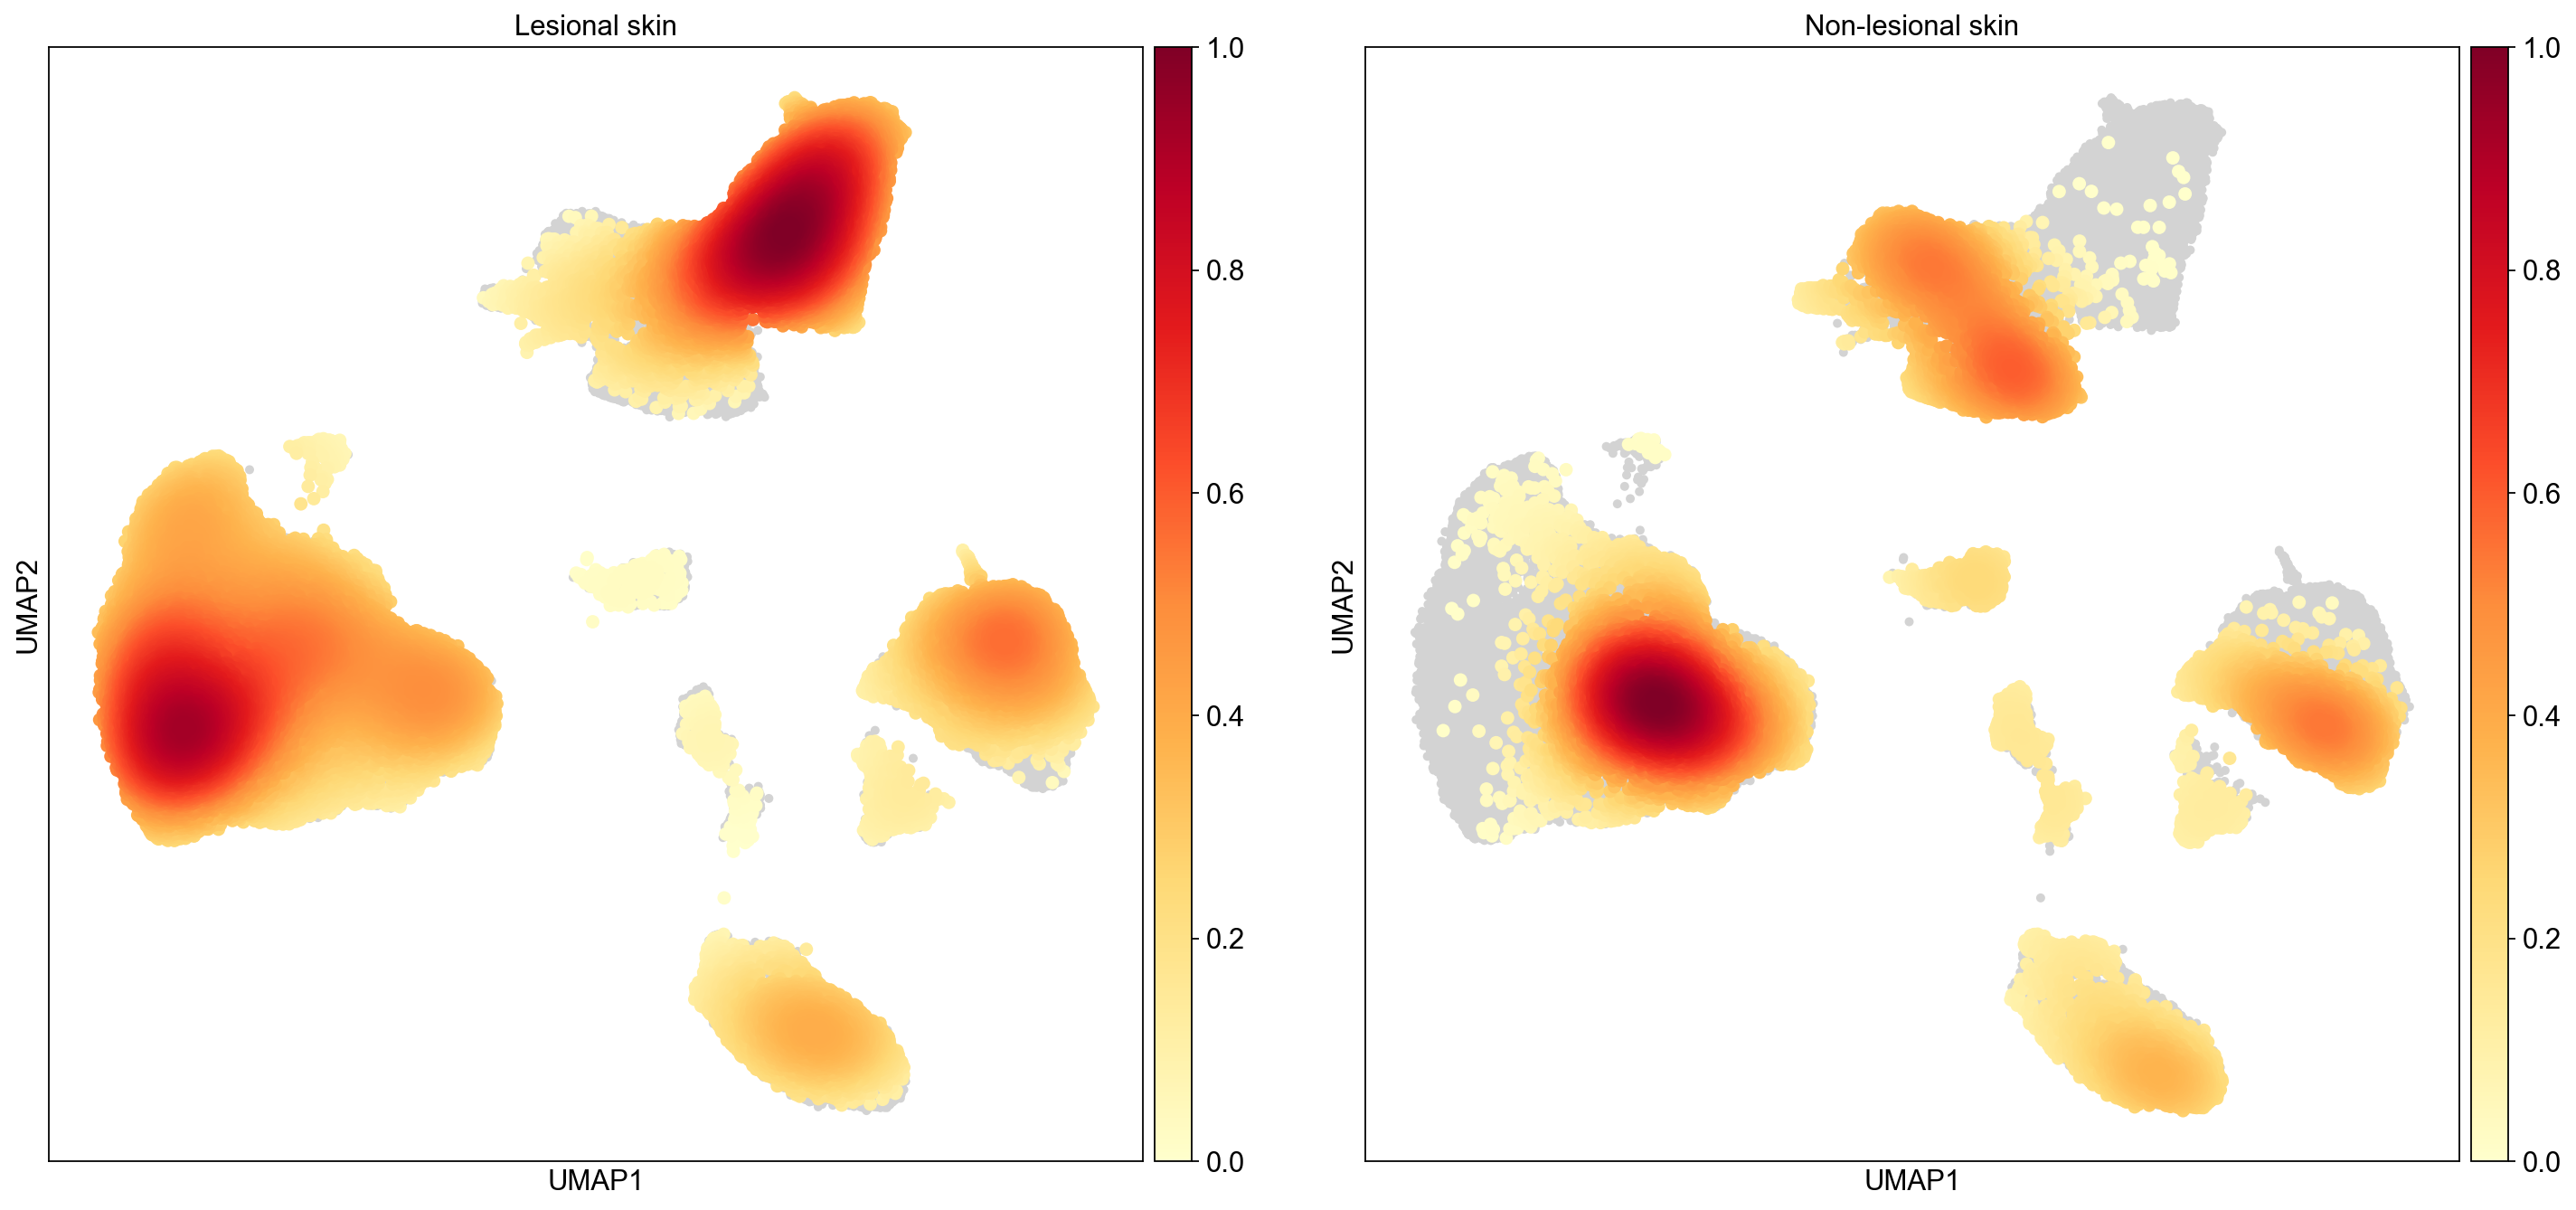

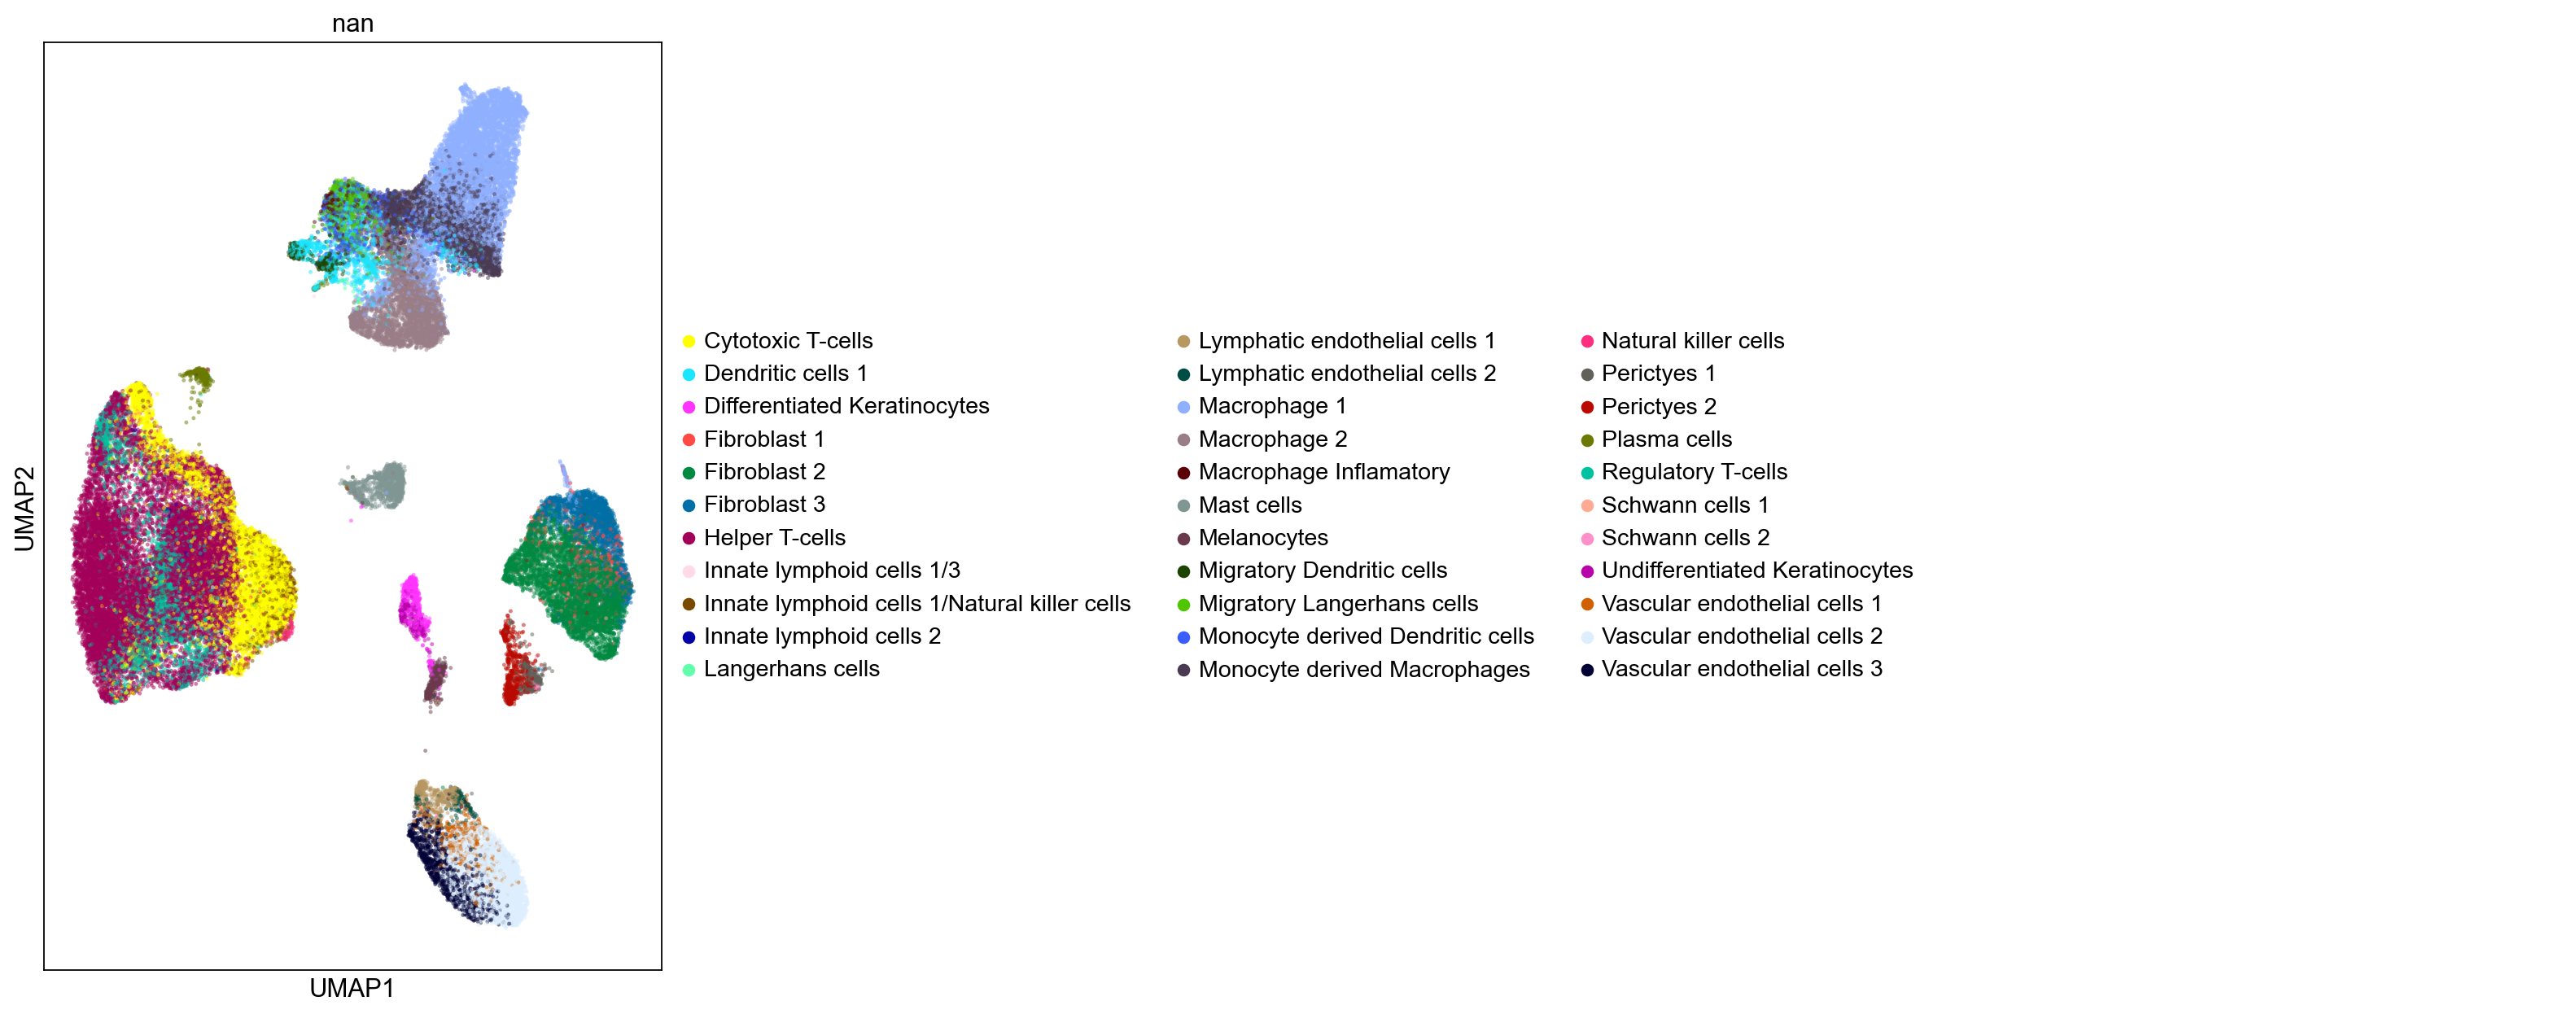

In [43]:
adata_prac=plot_densities(adata_prac)